In [242]:
import os
import random
import collections
import shutil
import time
import glob
import csv
import numpy as np

import torch
import torch.backends.cudnn as cudnn    
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = './dataset'

In [243]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [244]:
# paths
data_path = DATA_HOME_DIR + '/Face_Mask_Dataset' 
split_train_path = data_path + '/Train/'
full_train_path = data_path + '/train_full/'
valid_path = data_path + '/Validation/'
test_path = data_path + '/Test/'
saved_model_path = ROOT_DIR + '/models/'
submission_path = ROOT_DIR + '/submissions/'

In [245]:
def saveModel(model,path):
    torch.save(model, path)

In [246]:
def loadModel(path):
    return torch.load(path)

In [247]:
# data
batch_size = 8
epochs = 5
lr = 1e-4
clip = 0.001
archs = ["resnext50_32x4d"]
model_names = sorted(name for name in models.__dict__ if name.islower() and not name.startswith("__"))
best_prec1 = 0

In [315]:
print(model_names)

['_utils', 'alexnet', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'detection', 'googlenet', 'inception', 'inception_v3', 'mnasnet', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet', 'mobilenet_v2', 'quantization', 'resnet', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext50_32x4d', 'segmentation', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'shufflenetv2', 'squeezenet', 'squeezenet1_0', 'squeezenet1_1', 'utils', 'vgg', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'video', 'wide_resnet101_2', 'wide_resnet50_2']


In [249]:
#Helper Function for Training
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
    end = time.time()
    
    # switch to train mode
    model.train()
    
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.to(device)
        image_var = torch.autograd.Variable(images)
        label_var = torch.autograd.Variable(target)

        # compute y_pred
        y_pred = model(image_var)
        loss = criterion(y_pred, label_var)

        # measure accuracy and record loss
        prec1, prec1 = accuracy(y_pred.data, target, topk=(1, 1))
        losses.update(loss.data, images.size(0))
        acc.update(prec1, images.size(0))
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

In [250]:
def validate(val_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):
        labels = labels.to(device)
        image_var = torch.autograd.Variable(images)
        label_var = torch.autograd.Variable(labels)

        # compute y_pred
        y_pred = model(image_var)
        loss = criterion(y_pred, label_var)

        # measure accuracy and record loss
        prec1, temp_var = accuracy(y_pred.data, labels, topk=(1, 1))
        losses.update(loss.data, images.size(0))
        acc.update(prec1, images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    print('   * EPOCH {epoch} | Accuracy: {acc.avg:.3f} | Loss: {losses.avg:.3f}'.format(epoch=epoch,
                                                                                         acc=acc,
                                                                                         losses=losses))

    return acc.avg

In [309]:
def test(test_loader, model):
    csv_map = collections.defaultdict(float)
    # switch to evaluate mode
    nb_aug = 2
    nb_runs = 2
    model.eval()
    
    for aug in range(nb_aug):
        print("   * Predicting on test augmentation {}".format(aug + 1))
        
        for i, (images, filepath) in enumerate(test_loader):
            # pop extension, treat as id to map
            filepath = os.path.splitext(os.path.basename(filepath[0]))[0]
            filepath = int(filepath)

            image_var = torch.autograd.Variable(images)
            y_pred = model(image_var)
            # get the index of the max log-probability
            smax = nn.Softmax()
            smax_out = smax(y_pred)[0]
            cat_prob = smax_out.data[0]
            dog_prob = smax_out.data[1]
            prob = dog_prob
            if cat_prob > dog_prob:
                prob = 1 - cat_prob
            prob = np.around(prob.cpu(), decimals=4)
            prob = np.clip(prob, clip, 1-clip)
            csv_map[filepath] += (prob / nb_aug)


    sub_fn = submission_path + '{0}epoch_{1}clip_{2}runs'.format(epochs, clip, nb_runs)
    
    for arch in archs:
        sub_fn += "_{}".format(arch)

    print("Writing Predictions to CSV...")
    with open(sub_fn + '.csv', 'w') as csvfile:
        fieldnames = ['id', 'label']
        csv_w = csv.writer(csvfile)
        csv_w.writerow(('id', 'label'))
        for row in sorted(csv_map.items()):
            csv_w.writerow(row)
    print("Done.")

In [252]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')      

In [253]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [254]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    global lr
    lr = lr * (0.1**(epoch // 30))
    for param_group in optimizer.state_dict()['param_groups']:
        param_group['lr'] = lr


def accuracy(y_pred, y_actual, topk=(1, )):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = y_actual.size(0)

    _, pred = y_pred.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(y_actual.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res

In [255]:
class TestImageFolder(data.Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filename in sorted(glob.glob(test_path + "*.jpg")):
            images.append('{}'.format(filename))

        self.root = root
        self.imgs = images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)

In [306]:
#Main Training Loop
def main(mode="train", resume=False):
    
    global best_prec1
    
    for arch in archs:

        # create model
        print("=> Starting {0} on '{1}' model".format(mode, arch))
        model = models.__dict__[arch](pretrained=True)
        # Don't update non-classifier learned features in the pretrained networks
        for param in model.parameters():
            param.requires_grad = False
        # Replace the last fully-connected layer
        # Parameters of newly constructed modules have requires_grad=True by default
        # Final dense layer needs to replaced with the previous out chans, and number of classes
        # in this case -- resnet 101 - it's 2048 with two classes (cats and dogs)
        model.fc = nn.Linear(2048, 2)

        if arch.startswith('alexnet') or arch.startswith('vgg'):
            model.features = torch.nn.DataParallel(model.features)
            model.to(device)
        else:
            model = torch.nn.DataParallel(model).to(device)
            
        # optionally resume from a checkpoint
        if resume:
            if os.path.isfile(resume):
                print("=> Loading checkpoint '{}'".format(resume))
                checkpoint = torch.load(resume)
                start_epoch = checkpoint['epoch']
                best_prec1 = checkpoint['best_prec1']
                model.load_state_dict(checkpoint['state_dict'])
                print("=> Loaded checkpoint (epoch {})".format(checkpoint['epoch']))
            else:
                print("=> No checkpoint found at '{}'".format(args.resume))

        cudnn.benchmark = True

        # Data loading code
        traindir = split_train_path
        valdir = valid_path
        testdir = test_path

        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        train_loader = data.DataLoader(
            datasets.ImageFolder(traindir,
                                 transforms.Compose([
                                     transforms.Resize(96),
                                     transforms.CenterCrop(64),
                                     transforms.RandomResizedCrop(64),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     normalize,
                                 ])),
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True)

        val_loader = data.DataLoader(
            datasets.ImageFolder(valdir,
                                 transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize,
                                 ])),
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True)

        test_loader = data.DataLoader(
            TestImageFolder(testdir,
                            transforms.Compose([
                                transforms.Resize(96),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize,
                            ])),
            batch_size=1,
            shuffle=False,
            num_workers=1,
            pin_memory=False)
        
        
        if mode == "test":
            test(test_loader, model)
            return
         # define loss function (criterion) and pptimizer
        criterion = nn.CrossEntropyLoss().to(device)
        
        if mode == "validate":
            validate(val_loader, model, criterion, 0)
            return

        optimizer = optim.Adam(model.module.fc.parameters(), lr, weight_decay=1e-4)

        for epoch in range(epochs):
            adjust_learning_rate(optimizer, epoch)

            # train for one epoch
            %time train(train_loader, model, criterion, optimizer, epoch)
            saveModel(model=model,path=f'models/model-best-{epoch}.pth')


            # evaluate on validation set
            prec1 = validate(val_loader, model, criterion, epoch)

            # remember best Accuracy and save checkpoint
            is_best = prec1 > best_prec1
            best_prec1 = max(prec1, best_prec1)
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': arch,
                'state_dict': model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best)

In [258]:
main(mode="train")

=> Starting train on 'resnext50_32x4d' model
   * EPOCH 0 | Accuracy: 95.500 | Loss: 0.153
   * EPOCH 1 | Accuracy: 96.125 | Loss: 0.124
   * EPOCH 2 | Accuracy: 97.125 | Loss: 0.098
   * EPOCH 3 | Accuracy: 97.625 | Loss: 0.083
   * EPOCH 4 | Accuracy: 97.125 | Loss: 0.088


In [259]:
main(mode="validate", resume='model_best.pth.tar')

=> Starting validate on 'resnext50_32x4d' model
=> Loading checkpoint 'model_best.pth.tar'
=> Loaded checkpoint (epoch 4)
   * EPOCH 0 | Accuracy: 97.625 | Loss: 0.083


In [310]:
main(mode="test", resume='model_best.pth.tar')

=> Starting test on 'resnext50_32x4d' model
=> Loading checkpoint 'model_best.pth.tar'
=> Loaded checkpoint (epoch 4)
   * Predicting on test augmentation 1
   * Predicting on test augmentation 2
Writing Predictions to CSV...
Done.


In [295]:
# Load model
model = loadModel('./models/model-best4.pth')
model.eval()
print('Model loaded')

Model loaded


WithMask


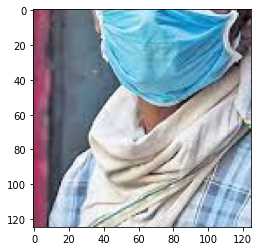

In [293]:
imsize = 256
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])
import matplotlib.pyplot as plt
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    plt.imshow(image)
    image = loader(image).float()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

def get_label(code):
    if code == 1:
        print('WithoutMask')
    else:
        print('WithMask')

image = image_loader('./dataset/Face_Mask_Dataset/Validation/WithMask/2.png')

get_label(torch.argmax(model(image)).item())

WithoutMask
CPU times: user 153 ms, sys: 5 µs, total: 153 ms
Wall time: 76.6 ms


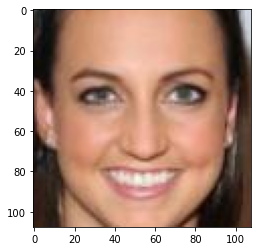

In [314]:
image = image_loader('./dataset/Face_Mask_Dataset/Validation/WithoutMask/2.png')

%time get_label(torch.argmax(model(image)).item())

In [ ]:
# sjkfkjfksjdbkSAD    